# A file where we harmonise

In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [74]:
# --- Model definition (same as training) ------------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, n_classes=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 25×25
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 12×12
        )
        self.fc = nn.Linear(32 * 12 * 12, n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


tensor(0.5543, device='cuda:0')


C:\Users\joche\AppData\Local\Temp\ipykernel_21808\810837080.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/small_cnn.pth", map_

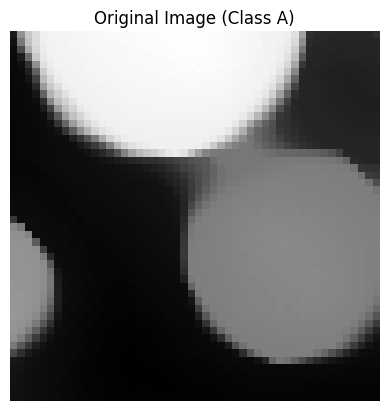

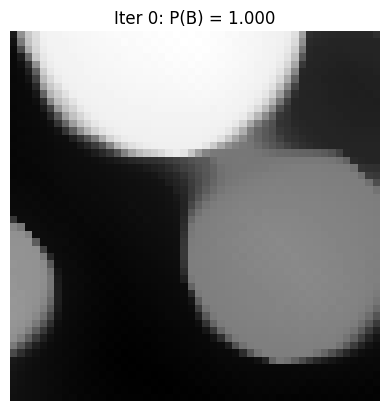

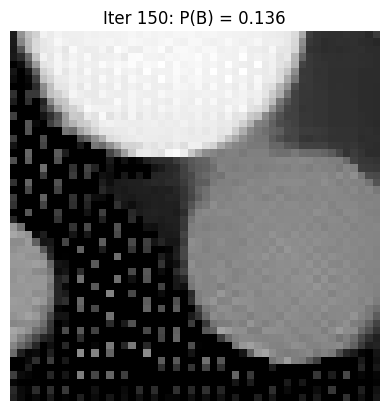

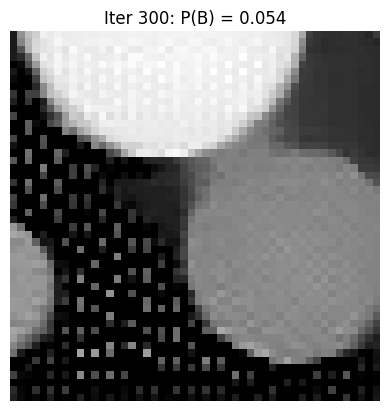

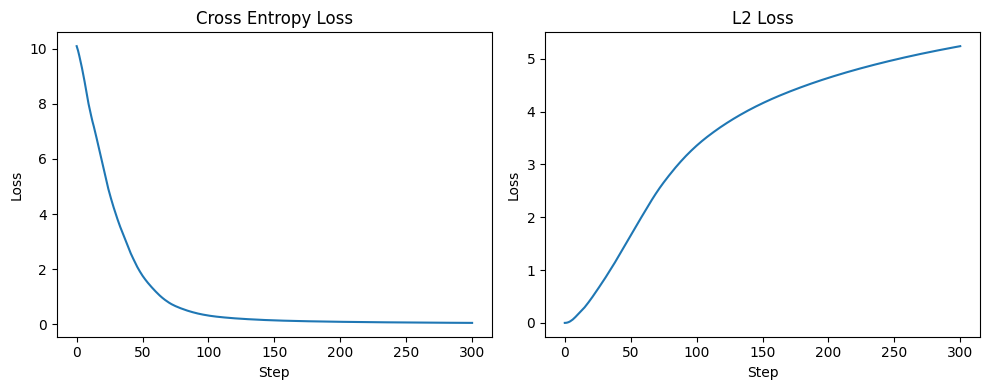

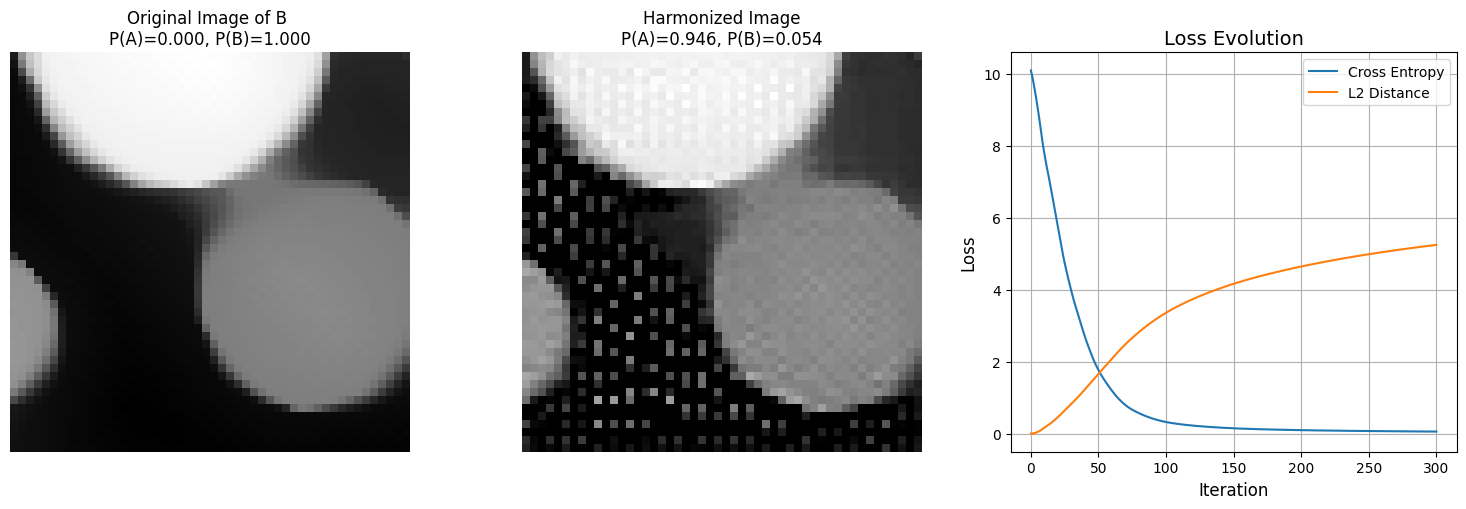

In [91]:

# --- Load classifier -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)
model.load_state_dict(torch.load("models/small_cnn.pth", map_location=device))
model.eval()

# --- Load an example image patch (class A) -------------------------
# Replace path if needed
A = np.load("data/augmented_images_algoB.npy")  # shape (N,50,50)

index_a = np.random.randint(0, A.shape[0])  # pick random sample # pick random sample
x0_np = A[index_a]                  # pick first sample
x0 = torch.from_numpy(x0_np).unsqueeze(0).unsqueeze(0).float()  # (1,1,50,50)
x0 = x0.to(device)

print(torch.max(x0))



plt.figure()
plt.imshow(x0_np, cmap='gray')
plt.title("Original Image (Class A)")
plt.axis('off')
plt.show()



# --- Optimization setup --------------------------------------------
target_label = torch.tensor([0], device=device)  # want class B
lambda_l2 = 100
lr = 0.0001
n_steps = 300
record_iters = [0, n_steps//2, n_steps]  # initial, mid, final

# prepare variable
x = x0.clone().detach().requires_grad_(True)

# records
records = []
ce_history = []  # Track cross entropy loss
l2_history = []  # Track L2 loss
step_history = []  # Track steps

for step in range(n_steps + 1):
    logits = model(x)
    ce = F.cross_entropy(logits, target_label)
    l2 = torch.norm(x - x0)**2
    loss =  l2 + lambda_l2 * ce
    
    # record losses at each step
    ce_history.append(ce.item())
    l2_history.append(l2.item())
    step_history.append(step)

    # record if needed
    if step in record_iters:
        probs = F.softmax(logits, dim=1)[0,1].item()  # P(class B)
        records.append((step, x.detach().cpu().squeeze().numpy(), probs))

    # gradient step (skip update at final record)
    if step < n_steps:
        loss.backward()
        with torch.no_grad():
            x.data -= lr * x.grad.data
            x.data.clamp_(0, 1)
        x.grad.zero_()

# --- Plot results ----------------------------------------------------
for step, img, score in records:
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Iter {step}: P(B) = {score:.3f}")
    plt.axis('off')

# Plot losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(step_history, ce_history)
plt.title('Cross Entropy Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(step_history, l2_history)
plt.title('L2 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# Get probabilities for original and final image
logits_orig = model(x0)
probs_orig = F.softmax(logits_orig, dim=1)[0].detach().cpu().numpy()

logits_final = model(x)
probs_final = F.softmax(logits_final, dim=1)[0].detach().cpu().numpy()

# Create figure
plt.figure(figsize=(15, 5))

# Plot original image
plt.subplot(131)
plt.imshow(x0_np, cmap='gray')
plt.title(f'Original Image of B \nP(A)={probs_orig[0]:.3f}, P(B)={probs_orig[1]:.3f}')
plt.axis('off')

# Plot harmonized image
plt.subplot(132)
plt.imshow(records[-1][1], cmap='gray')
plt.title(f'Harmonized Image\nP(A)={probs_final[0]:.3f}, P(B)={probs_final[1]:.3f}')
plt.axis('off')

# Plot losses
plt.subplot(133)
plt.plot(step_history, ce_history, label='Cross Entropy')
plt.plot(step_history, l2_history, label='L2 Distance')
plt.title('Loss Evolution', fontsize = 14)
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## harmonisation different side

tensor(0.6450, device='cuda:0')


C:\Users\joche\AppData\Local\Temp\ipykernel_21808\2160812807.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/small_cnn.pth", map

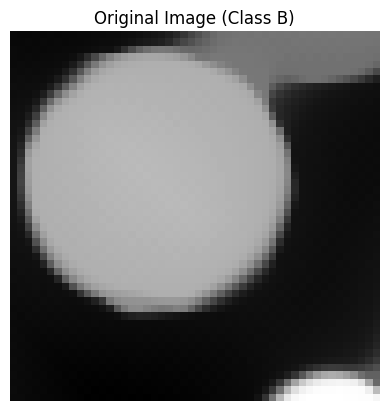

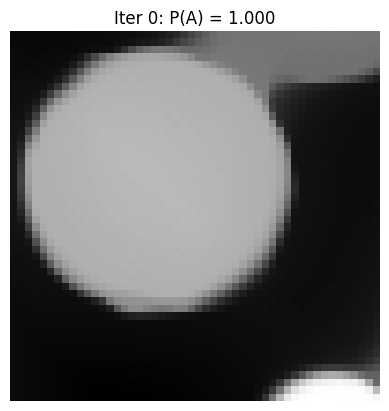

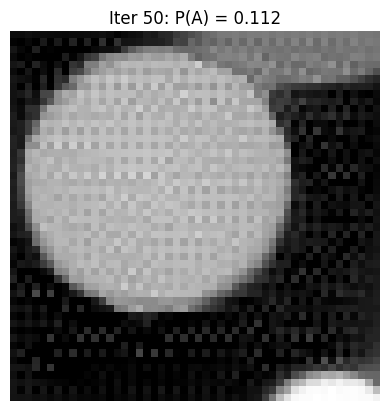

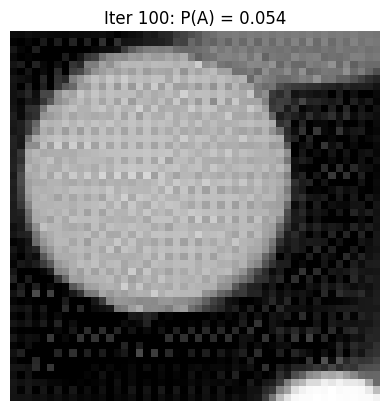

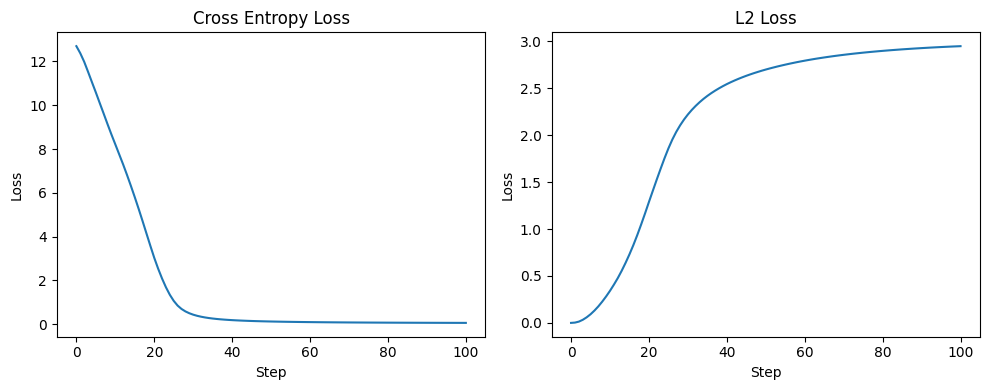

In [20]:
# --- Load classifier -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)
model.load_state_dict(torch.load("models/small_cnn.pth", map_location=device))
model.eval()

# --- Load an example image patch (class B) -------------------------
# Replace path if needed
B = np.load("data/augmented_images_algoB.npy")  # shape (N,50,50)
# pick random sample
index_b = np.random.randint(0, B.shape[0])  # pick random sample
x0_np = B[index_b]                  # pick first sample
x0 = torch.from_numpy(x0_np).unsqueeze(0).unsqueeze(0).float()  # (1,1,50,50)
x0 = x0.to(device)

print(torch.max(x0))



plt.figure()
plt.imshow(x0_np, cmap='gray')
plt.title("Original Image (Class B)")
plt.axis('off')
plt.show()



# --- Optimization setup --------------------------------------------
target_label = torch.tensor([0], device=device)  # Want class A
lambda_l2 = 10
lr = 0.001
n_steps = 100
record_iters = [0, n_steps//2, n_steps]  # initial, mid, final

# prepare variable
x = x0.clone().detach().requires_grad_(True)

# records
records = []
ce_history = []  # Track cross entropy loss
l2_history = []  # Track L2 loss
step_history = []  # Track steps

for step in range(n_steps + 1):
    logits = model(x)
    ce = F.cross_entropy(logits, target_label)
    l2 =  torch.norm(x - x0)**2
    loss =  l2 + lambda_l2 * ce 
    
    # record losses at each step
    ce_history.append(ce.item())
    l2_history.append(l2.item())
    step_history.append(step)

    # record if needed
    if step in record_iters:
        probs = F.softmax(logits, dim=1)[0,1].item()  # P(class B)
        records.append((step, x.detach().cpu().squeeze().numpy(), probs))

    # gradient step (skip update at final record)
    if step < n_steps:
        loss.backward()
        with torch.no_grad():
            x.data -= lr * x.grad.data
            x.data.clamp_(0, 1)
        x.grad.zero_()

# --- Plot results ----------------------------------------------------
for step, img, score in records:
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Iter {step}: P(A) = {score:.3f}")
    plt.axis('off')

# Plot losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(step_history, ce_history)
plt.title('Cross Entropy Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(step_history, l2_history)
plt.title('L2 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# compare how the harmonisation works

1. load in full images of A and B
2. cut out the same part of the image for A and B.
3. Do a harmonisation both ways
4. plot the results beside each others. with a MSE plot

make it such that the plot cuts of A and B are random but the same for each image

(10, 256, 256)
124 134
9


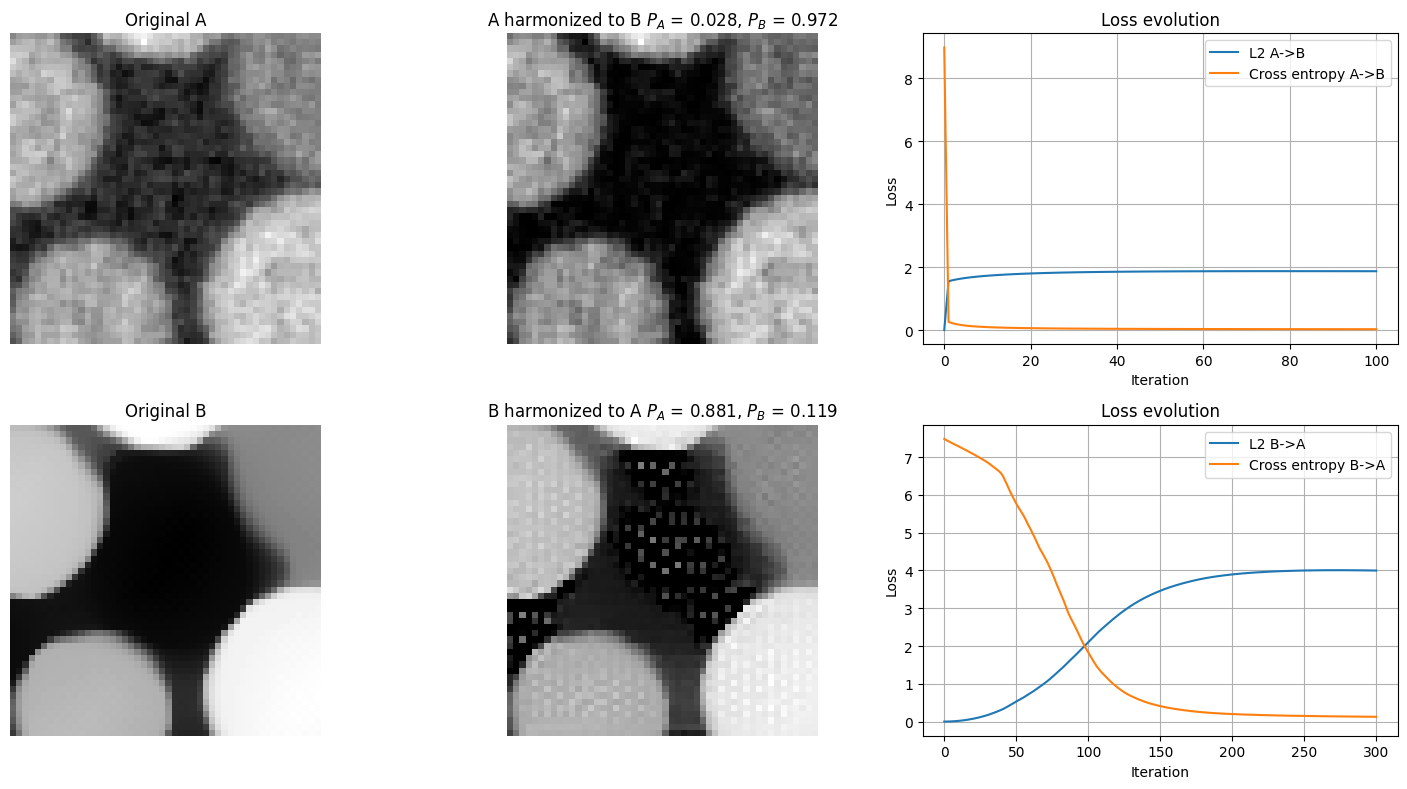

In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to harmonize image
def harmonize_image(model, x0, target_label, lambda_l2=10, lr=0.001, n_steps=100):
    x = x0.clone().detach().requires_grad_(True)
    
    ce_history = []
    l2_history = []
    final_img = None
    
    for step in range(n_steps + 1):
        logits = model(x)
        ce = F.cross_entropy(logits, target_label)
        l2 = torch.norm(x - x0)**2
        loss = l2 + lambda_l2 * ce
        
        ce_history.append(ce.item())
        l2_history.append(l2.item())
        
        if step < n_steps:
            loss.backward()
            with torch.no_grad():
                x.data -= lr * x.grad.data
                x.data.clamp_(0, 1)
            x.grad.zero_()
        else:
            final_img = x.detach().cpu().squeeze().numpy()
    
    return final_img, ce_history, l2_history


# Load in full images
A_full = np.load("data/full_images_algoA.npy")  # shape (N,50,50)
B_full = np.load("data/full_images_algoB.npy")  # shape (N,50,50)

A_full = np.array([A_full[i,0,0,:,:] for i in range(A_full.shape[0])])
B_full = np.array([B_full[i,0,0,:,:] for i in range(B_full.shape[0])])
# Random crop positions (same for both images)
print(A_full.shape)
h, w = A_full[0].shape
crop_size = 50
top = np.random.randint(0, h - crop_size)
left = np.random.randint(0, w - crop_size)

print(top, left)
# Extract patches
n_index = np.random.randint(0, A_full.shape[0])  # pick random sample
print(n_index)

patch_A = A_full[n_index, top:top+crop_size, left:left+crop_size]
patch_B = B_full[n_index, top:top+crop_size, left:left+crop_size]

# Convert to torch tensors
x0_A = torch.from_numpy(patch_A).unsqueeze(0).unsqueeze(0).float().to(device)
x0_B = torch.from_numpy(patch_B).unsqueeze(0).unsqueeze(0).float().to(device)

# Harmonize A to B
result_A2B, ce_A2B, l2_A2B = harmonize_image(model, x0_A, torch.tensor([1], device=device))

# Harmonize B to A
result_B2A, ce_B2A, l2_B2A = harmonize_image(model, x0_B, torch.tensor([0], device=device), n_steps = 300)

# run the model on the harmonized images to get the probabilities
logits_A2B = model(torch.from_numpy(result_A2B).unsqueeze(0).unsqueeze(0).float().to(device))
logits_B2A = model(torch.from_numpy(result_B2A).unsqueeze(0).unsqueeze(0).float().to(device))
probs_A2B = F.softmax(logits_A2B, dim=1)[0].detach().cpu().numpy()
probs_B2A = F.softmax(logits_B2A, dim=1)[0].detach().cpu().numpy()

# Plot results
plt.figure(figsize=(15, 8))

# Original images and harmonization results
plt.subplot(231)
plt.imshow(patch_A, cmap='gray')
plt.title('Original A')
plt.axis('off')

plt.subplot(232)
plt.imshow(result_A2B, cmap='gray')
plt.title(r'A harmonized to B $P_A$ = {:.3f}, $P_B$ = {:.3f}'.format(probs_A2B[0], probs_A2B[1]))
plt.axis('off')

plt.subplot(233)
plt.plot(l2_A2B, label='L2 A->B')
plt.plot(ce_A2B, label='Cross entropy A->B')
plt.title('Loss evolution')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(234)
plt.imshow(patch_B, cmap='gray')
plt.title('Original B')
plt.axis('off')

plt.subplot(235)
plt.imshow(result_B2A, cmap='gray')
plt.title(r'B harmonized to A $P_A$ = {:.3f}, $P_B$ = {:.3f}'.format(probs_B2A[0], probs_B2A[1]))
plt.axis('off')

plt.subplot(236)
plt.plot(l2_B2A, label='L2 B->A')
plt.plot(ce_B2A, label='Cross entropy B->A')
plt.title('Loss evolution')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# # Plot loss histories
# plt.figure(figsize=(12, 4))
# plt.subplot(121)
# plt.plot(ce_A2B, label='A->B')
# plt.plot(ce_B2A, label='B->A')
# plt.title('Cross Entropy Loss')
# plt.legend()

# plt.subplot(122)
# plt.plot(l2_A2B, label='A->B')
# plt.plot(l2_B2A, label='B->A')
# plt.title('L2 Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()




# Do a pca on the orgianl data and the A and B and the harmonisation A and B plot the results.

(2, 50, 50)


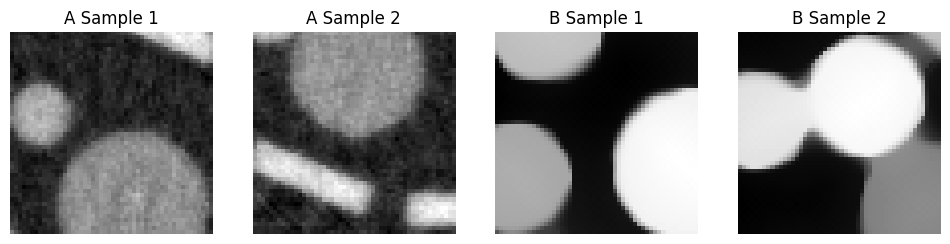

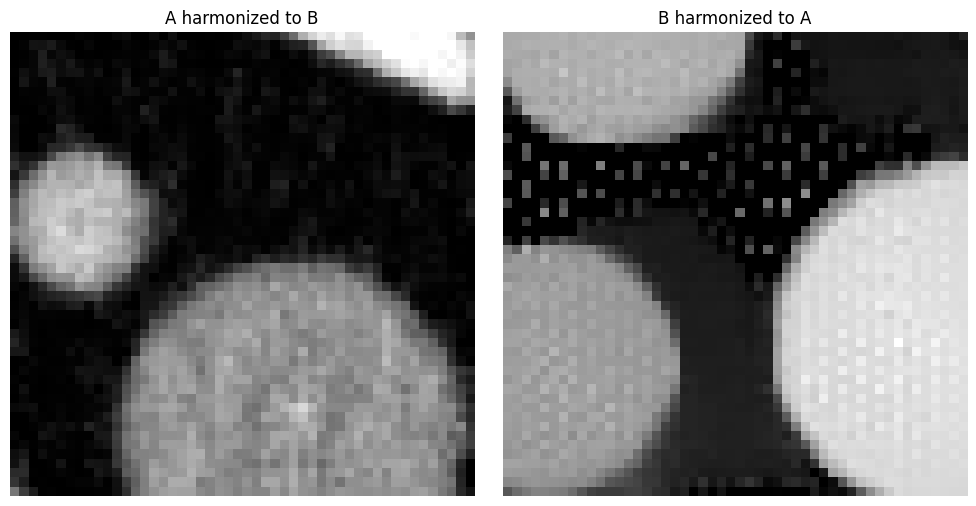

(2, 50, 50)


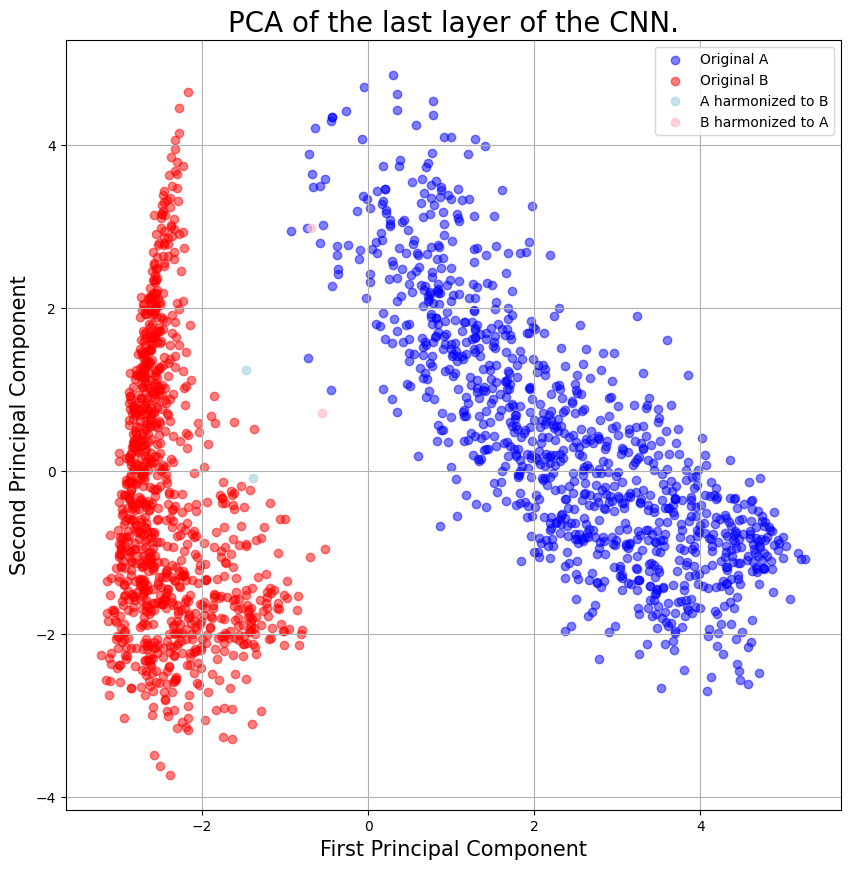

PCA explained variance ratio: [0.18433167 0.07040026]


In [ ]:
# Load full datasets
A = np.load("data/augmented_images_algoA.npy")
B = np.load("data/augmented_images_algoB.npy")



# Select 100 random samples from each
# np.random.seed(41)  # for reproducibility
A_indices = np.random.choice(A.shape[0], 100, replace=False)
B_indices = np.random.choice(B.shape[0], 100, replace=False)



A_subset = A[A_indices]
B_subset = B[B_indices]

# Plot original A and B subset images
plt.figure(figsize=(12, 6))

# Plot A subset
plt.subplot(241)
plt.imshow(A_subset[0], cmap='gray')
plt.title('A Sample 1')
plt.axis('off')

plt.subplot(242)
plt.imshow(A_subset[1], cmap='gray')
plt.title('A Sample 2')
plt.axis('off')

# Plot B subset
plt.subplot(243)
plt.imshow(B_subset[0], cmap='gray')
plt.title('B Sample 1')
plt.axis('off')

plt.subplot(244)
plt.imshow(B_subset[1], cmap='gray')
plt.title('B Sample 2')
plt.axis('off')


# Function to get features from the last convolutional layer
def get_features_from_batch(model, x):
    x = torch.from_numpy(x).unsqueeze(1).float().to(device)
    with torch.no_grad():
        features = model.conv(x)
        features = features.view(features.size(0), -1)
    return features.cpu().numpy()

# Function to harmonize batch of images
def harmonize_batch(model, xs, target_label, lambda_l2=10, lr=0.001, n_steps=100):
    xs = torch.from_numpy(xs).unsqueeze(1).float().to(device)
    xs = xs.clone().detach().requires_grad_(True)

    harmonize_batch = []
    for x in xs:
        x = x.unsqueeze(0)  # Add batch dimension
        harmnonized_image,_ , _  = harmonize_image(model,x, torch.tensor([target_label], device=device), lambda_l2=lambda_l2, lr=lr, n_steps=n_steps)
        harmonize_batch.append(harmnonized_image)
    
    
    return np.array(harmonize_batch)

# Get features for original data
features_A = get_features_from_batch(model, A)
features_B = get_features_from_batch(model, B)

# Harmonize subsets
A2B = harmonize_batch(model, A_subset, target_label=1, n_steps = 50)
B2A = harmonize_batch(model, B_subset, target_label=0, n_steps=300)

print(A2B.shape)
i = 0
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(A2B[i], cmap='gray')
plt.title('A harmonized to B')
plt.axis('off')
plt.subplot(122)
plt.imshow(B2A[i], cmap='gray')
plt.title('B harmonized to A')
plt.axis('off')
plt.tight_layout()
plt.show()

print(B2A.shape)

# Get features for harmonized data
features_A2B = get_features_from_batch(model, A2B)
features_B2A = get_features_from_batch(model, B2A)

# Combine all features for PCA
all_features = np.vstack([features_A, features_B, features_A2B, features_B2A])
pca = PCA(n_components=2)
features_pca = pca.fit_transform(all_features)

# Split back into groups
n_A = features_A.shape[0]
n_B = features_B.shape[0]
n_A2B = features_A2B.shape[0]
n_B2A = features_B2A.shape[0]

pca_A = features_pca[:n_A]
pca_B = features_pca[n_A:n_A+n_B]
pca_A2B = features_pca[n_A+n_B:n_A+n_B+n_A2B]
pca_B2A = features_pca[n_A+n_B+n_A2B:]

# Plot results
plt.figure(figsize=(10, 10))
plt.scatter(pca_A[:,0], pca_A[:,1], alpha=0.5, label='Original A', color='blue')
plt.scatter(pca_B[:,0], pca_B[:,1], alpha=0.5, label='Original B', color='red')
plt.scatter(pca_A2B[:,0], pca_A2B[:,1], alpha=0.7, label='A harmonized to B', color='lightblue')
plt.scatter(pca_B2A[:,0], pca_B2A[:,1], alpha=0.7, label='B harmonized to A', color='pink')

plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.title('PCA of the last layer of the CNN.', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratio
print("PCA explained variance ratio:", pca.explained_variance_ratio_)